In [2]:
### addtiional info: https://www.gpxz.io/blog/gpx-file-to-pandas
#### https://towardsdatascience.com/parsing-fitness-tracker-data-with-python-a59e7dc17418

import gpxpy
import gpxpy.gpx
import geopy.distance
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from typing import Dict, Union
from datetime import datetime
from numpy_ext import rolling_apply
import numpy as np
import glob
from io import StringIO
from csv import writer 


# Apply the default theme
sns.set_theme()

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [3]:
# appending rows in df is slow, faster to create in csv in memory and then import csv

output = StringIO()
csv_writer = writer(output)

COLUMN_NAMES = ['latitude', 'longitude', 'elevation', 'time','speed_in_meters', 'heart_rate', ]
NAMESPACES = {'garmin_tpe': 'http://www.garmin.com/xmlschemas/TrackPointExtension/v1'}
    
# loop thorugh all top 100 files in folder
for f in glob.glob("2022*.gpx"):
    print(f)
    with open(f, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)
    try:
        segment = gpx.tracks[0].segments[0]  # Assuming we know that there is only one track and one segment
        for point_idx, point in enumerate(segment.points):
            
            try:
                elem = point.extensions[0]
                hea = (int(elem.find('garmin_tpe:hr', NAMESPACES).text))
            except:
                hea = 0
                
            row = [point.latitude,
                                 point.longitude,
                                 point.elevation,
                                 point.time,
                                 segment.get_speed(point_idx),
                                 hea]
            csv_writer.writerow(row)

    except Exception as e: 
        print(e)

output.seek(0) # we need to get back to the start of the BytesIO
df = pd.read_csv(output, header=None, names=COLUMN_NAMES)

2022-06-30.gpx
2022-07-05.gpx
2022-07-25.gpx
2022-07-27.gpx
2022-07-30.gpx
2022-08-02.gpx
2022-08-13.gpx
2022-08-16.gpx
2022-08-19.gpx
2022-09-07.gpx
2022-09-08.gpx
2022-09-10.gpx
2022-09-12.gpx
2022-09-15.gpx
2022-09-20.gpx
2022-09-24.gpx
2022-10-08.gpx
2022-10-11.gpx
2022-10-13.gpx
2022-10-15.gpx
2022-10-18.gpx
2022-10-20.gpx
2022-10-22.gpx
2022_09_22.gpx


In [4]:
# get max heartrate
print(df[df['heart_rate']==df['heart_rate'].max()])

        latitude  longitude  elevation                       time  \
26433  40.668592 -73.969003       44.5  2022-08-02 22:31:01+00:00   
26434  40.668642 -73.969038       44.7  2022-08-02 22:31:02+00:00   
26442  40.669099 -73.969109       46.7  2022-08-02 22:31:10+00:00   
26449  40.669491 -73.968950       48.4  2022-08-02 22:31:17+00:00   

       speed_in_meters  heart_rate  
26433         6.512987         182  
26434         6.273238         182  
26442         6.260962         182  
26449         6.863035         182  


In [5]:
# get distance.
coords = [(p.latitude, p.longitude) for p in df.itertuples()]
df['distance_meters'] = [0] + [geopy.distance.distance(from_, to).m for from_, to in zip(coords[:-1], coords[1:])]
df['cumulative_miles'] = df.distance_meters.cumsum() *0.000621371 

In [6]:
# get date
df['time'] = pd.to_datetime(df['time'])
df['date'] = (df['time'].dt.date)


In [7]:
# convert to mph
df['realspeed'] = df['speed_in_meters'] * 2.23694 # convert to mph
df['rolling_realspeed'] = df['realspeed'].rolling(10).mean() # using rolling average to smooth out


In [8]:
# get avg over time
hrdf = df.groupby(["date"], as_index=False)['heart_rate'].mean()
sdf = df.groupby(['date'], as_index=False)['realspeed'].mean() 
gdf = sdf.join(hrdf.set_index('date'), on='date')

ddf = df.groupby(['date'], as_index=False)['distance_meters'].sum() 
gdf = gdf.join(ddf.set_index('date'), on='date')

# change distance to miles from meters
gdf['distance'] = gdf['distance_meters'] * 0.000621371
gdf

,date,realspeed,heart_rate,distance_meters,distance
0,2022-06-30,17.747995,0.000000,16449.175281,10.221040
1,2022-07-05,17.853207,0.000000,20224.300343,12.566794
2,2022-07-25,17.093557,0.000000,18301.946167,11.372299
3,2022-07-27,17.345483,0.000000,26488.450307,16.459155
4,2022-07-30,13.765564,144.676033,81843.638020,50.855263
5,2022-08-02,17.325035,155.496943,26633.860227,16.549508
6,2022-08-13,16.434460,140.551794,18289.420101,11.364515
7,2022-08-16,17.912004,153.300667,19466.846703,12.096134
8,2022-08-19,16.858944,153.424353,27258.239389,16.937479
9,2022-09-07,17.494109,153.495150,18960.052307,11.781227


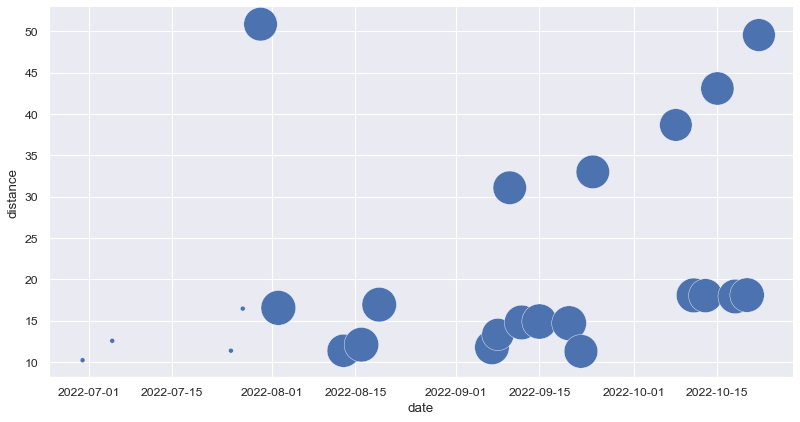

In [9]:
figure(figsize=(12, 6), dpi=80)

# use the scatterplot function to build the bubble map
sns.scatterplot(data=gdf, x="date", y="distance", size="heart_rate", legend=False, sizes=(20, 1000))

# show the graph
plt.show()

In [11]:
# lets look at GAP loop times and compare them
# Start of GAP Loop: 40.671195, -73.970027
gap = pd.DataFrame(df)
gap = gap.loc[gap['latitude'].round(3) == 40.671]
gap = gap.loc[gap['longitude'].round(4) == -73.9702]

In [12]:
gap['looptime'] = (gap['time']-gap['time'].shift())
gap['looptime'] = gap['looptime'].fillna(pd.Timedelta(seconds=0))

In [13]:
# filter out loops w unreasonable times (either a few sec because of rounding or over mulitple loops or mulitple days )
gap = gap.loc[gap['looptime'] > pd.Timedelta(4, unit='m')]
gap = gap.loc[gap['looptime'] < pd.Timedelta(30, unit='m')]
gap['looptime'] = gap['looptime'].dt.seconds / 60
gap.shape

gap

,latitude,longitude,elevation,time,speed_in_meters,heart_rate,distance_meters,cumulative_miles,date,realspeed,rolling_realspeed,looptime
725,40.671150,-73.970191,48.8,2022-06-30 13:04:41+00:00,9.342203,0,10.123486,3.477029,2022-06-30,20.897948,19.321690,11.733333
1416,40.671091,-73.970225,48.8,2022-06-30 13:16:12+00:00,9.426120,0,8.722807,6.866288,2022-06-30,21.085664,19.454785,11.516667
3376,40.671115,-73.970220,48.8,2022-07-05 22:31:02+00:00,8.220835,0,8.739033,17.033945,2022-07-05,18.389515,18.888145,11.583333
4086,40.671123,-73.970227,48.8,2022-07-05 22:42:53+00:00,8.411948,0,7.831387,20.426494,2022-07-05,18.817022,18.896078,11.850000
5344,40.671087,-73.970233,48.8,2022-07-25 12:47:17+00:00,9.142452,0,9.200102,26.734542,2022-07-25,20.451117,20.689912,10.433333
6093,40.671119,-73.970152,48.8,2022-07-25 12:59:46+00:00,8.148606,0,8.340984,30.129929,2022-07-25,18.227943,17.557441,12.483333
7668,40.671162,-73.970152,48.8,2022-07-27 12:52:43+00:00,9.393012,0,9.105742,37.987637,2022-07-27,21.011605,19.678946,11.466667
8617,40.671064,-73.970239,48.8,2022-07-27 13:08:33+00:00,8.438774,0,8.752032,42.539097,2022-07-27,18.877032,18.943178,15.833333
9348,40.671174,-73.970229,48.8,2022-07-27 13:20:52+00:00,7.688949,0,7.783407,45.935976,2022-07-27,17.199717,17.879327,12.316667
10029,40.671134,-73.970156,48.8,2022-07-27 13:32:13+00:00,8.193556,0,8.534770,49.326705,2022-07-27,18.328494,18.011951,11.350000


In [14]:
# map points to ensure in right area
import folium

route_map = folium.Map(
    location=[40.671195, -73.970027],
    zoom_start=40,
    tiles='CartoDBPositron',
    width=1024,
    height=600
)

for _, row in gap.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
    ).add_to(route_map)

display(route_map)

(5.0, 15.0)

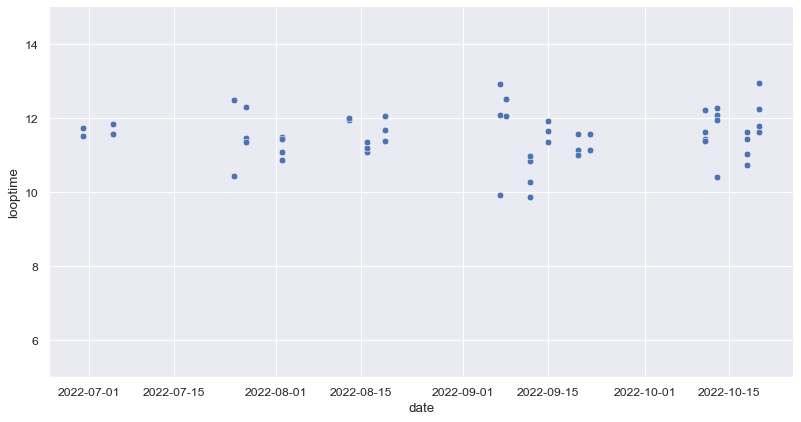

In [15]:
# use the scatterplot function to plot lap times over time
figure(figsize=(12, 6), dpi=80)
gplt = sns.scatterplot(data=gap, x="date", y="looptime")
gplt.set_ylim(5,15)


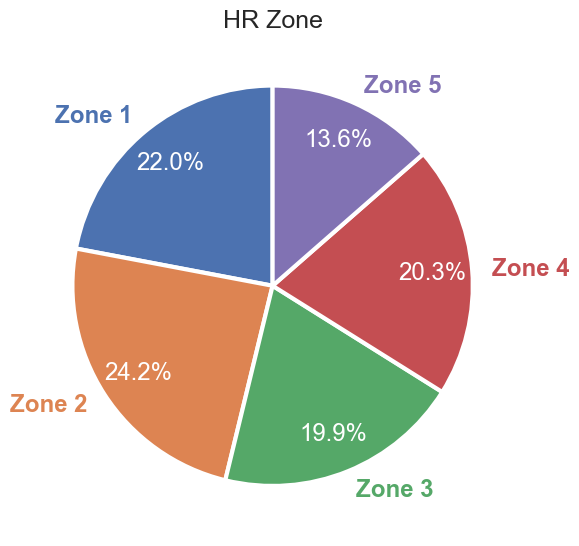

In [16]:
# total training volume by HR zones
HR_zone_bins = [0, 131, 144, 151, 160, 200] # based off max hr
#HR_zone_bins = [0, 108, 129, 139, 159, 200] # based off LTHR
hr_count, division = np.histogram(df['heart_rate'], bins = HR_zone_bins)
hr_count = pd.DataFrame(hr_count)
x = hr_count[0]

labels = ['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5']

fig, ax = plt.subplots(figsize=(6, 6))

patches, texts, pcts = ax.pie(
    x, labels=labels, pctdistance=0.8, # controls distance from center of %
    autopct='%.1f%%',
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'},
    startangle=90)
# For each wedge, set the corresponding text label color to the wedge's
# face color.
for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=600)
ax.set_title('HR Zone', fontsize=18)

plt.tight_layout()

In [24]:
df['HR_bin'] = pd.cut(df['heart_rate'], HR_zone_bins, labels=labels)


In [25]:
# calc relative effort across workouts (similar method to Strava but on a different scale as don't know their coefficients)

effort = pd.pivot_table(df, values='heart_rate', index=['date'],
                    columns=['HR_bin'], aggfunc='count')
effort

HR_bin,Zone 1,Zone 2,Zone 3,Zone 4,Zone 5
date,,,,,
2022-06-30,0,0,0,0,0
2022-07-05,0,0,0,0,0
2022-07-25,0,0,0,0,0
2022-07-27,0,0,0,0,0
2022-07-30,1605,4201,3991,2836,677
2022-08-02,116,300,630,1168,1221
2022-08-13,626,784,485,375,182
2022-08-16,125,343,369,728,833
2022-08-19,186,415,510,1630,815


In [50]:
effort['rel_effort'] = (effort['Zone 1'] + effort['Zone 2']*2 + effort['Zone 3']*4 + effort['Zone 4']*7.5 + effort['Zone 5']*15)/1000

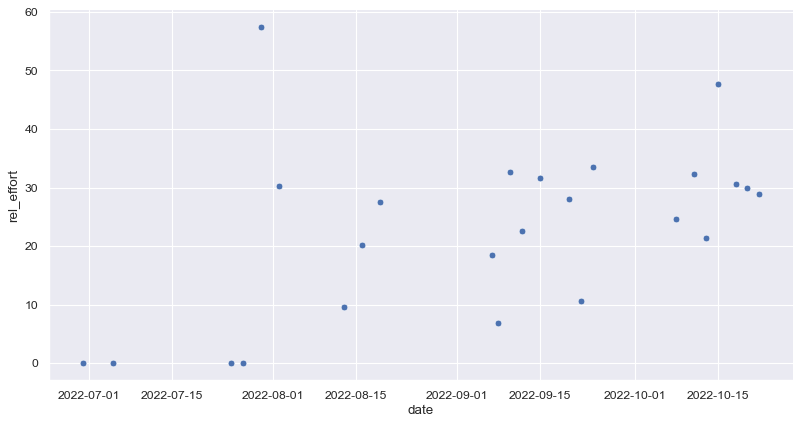

In [51]:
figure(figsize=(12, 6), dpi=80)
gplt = sns.scatterplot(data=effort, x="date", y="rel_effort")